# Plotting code for new data-saving mechanism: saving data from each trial in one dictionary

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
import torch

/home/yz685/anaconda3/envs/saasbo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Questions we are trying to answer:

- Does changing the initial sampling scheme accelerate the function optimization?
- How well does each initial sampling scheme identify important dimensions?
- How quickly does the posterior concentrate?
- Comparing different sampling schemes: random vs. dyadic -- how often do the perturbed dimensions actually include an important dimension (from an oracle point of view)

can we calculate the entropy on which dimensions are important from the empirical posterior samples?

- in theory, the NUTS sampling produces a collection of length scales for each dimensions
- right now I'm just logging the median
- but, for each dimensions, can also extract the fraction of samples where it's large (i.e., unimportant)
- or the average ranking of each dimensions among all 50
- this will help with calculating the entropy? TODO: derive math expression

In [2]:
def get_lengthscale_stats(l, n_top = 6, thres = 0.1):
    quantile = []
    count_below_threshold = []
    var = []

    for i in range(l.shape[0]):
        quantile.append(sorted(l[i])[n_top-1])
        #print(sorted(l[i])[n_top-1])
        count_below_threshold.append(sum(l[i]<thres))
        var.append(np.var(l[i]))
    
    #print(quantile)
    
    return quantile, count_below_threshold, var

In [3]:
# function that takes a list of lists and outputs mean and sd
def process_multiple_trials(values, log_transform = False):
    n_trials = len(values)
    values_array = np.array(values)
    if log_transform:
        values_array = np.log(values_array+1)
    # print(values_array.shape)
    mean = np.mean(values_array, axis = 0)
    sd_mean = np.std(values_array, axis = 0) / (n_trials ** 0.5)
    # print(mean.shape, sd_mean.shape)

    return mean, sd_mean

# Compare:
* Protocol for choosing which dimensions to perturb: dyadic or random
* Direction of perturbation: set to upper bound with probabiltiy 1, or set to upper / lower bound with equal probability

In [4]:
IMPORTANT_DIMS = {
    'branin_1000': [17, 876],
    'hartmann6_1000': [1, 7, 11, 23, 47, 33]
}

In [27]:
# problem = 'hartmann6_50'
# problem = 'hartmann6_1000'
problem = 'branin_1000'
important_dims = IMPORTANT_DIMS[problem]



perturb_dims_policies = ['random']
perturb_directions = ['ub_only', 'ub_and_lb']
fracs_initevals_perturbed = [0, 0.2, 0.5, 0.8, 1]
fracs_dims_perturbed = [0.1, 0.2, 0.5]

# n_initevals_list = ['10', '20', '30']
n_initevals_list = ['30']
trials = list(range(1, 11))

In [28]:
combinations = itertools.product(perturb_dims_policies, n_initevals_list, fracs_initevals_perturbed, fracs_dims_perturbed, perturb_directions)

In [29]:
start = 3

lengthscale_quantiles = {}

for perturb_dim_policy, n_initevals, frac_initevals_perturbed, frac_dims_perturbed, perturb_direction in combinations:

    qs = []

    frac_initevals_perturbed_str = str(frac_initevals_perturbed).replace('.', '')
    frac_dims_perturbed_str = str(frac_dims_perturbed).replace('.', '')

    for trial in trials:
        file = '/home/yz685/saasbo/results/' + problem + '/random_vs_dyadic/' + perturb_dim_policy + \
                '_initevals=' + n_initevals + '_frac_initevals_perturbed=' + frac_initevals_perturbed_str + \
                '_frac_dims_perturbed=' + frac_dims_perturbed_str + '/' + perturb_direction + str(trial)

        results = torch.load(file)
        q, c, v = get_lengthscale_stats(np.expand_dims(results['median_lengthscales'][0], 0), thres = 5)
        qs.append(q)
        
    q_mean, q_sd = process_multiple_trials(qs, log_transform = True)
    lengthscale_quantiles[(perturb_dim_policy, n_initevals, frac_initevals_perturbed, frac_dims_perturbed, perturb_direction)] = [q_mean, q_sd]
    
#     plt.plot(np.arange(3, len(q_mean)), q_mean[start:])
#     plt.fill_between(
#         np.arange(3, len(q_mean)),
#         q_mean[start:] - 2*q_sd[start:],
#         q_mean[start:] + 2*q_sd[start:],
#         alpha = 0.3,
#         label = perturb_dim_policy + '_' + perturb_direction
#     )
# plt.legend(bbox_to_anchor=(1, 1))
# plt.title('Log sixth smallest lengthscale in '+problem)

In [30]:
print(lengthscale_quantiles.keys())

dict_keys([('random', '30', 0, 0.1, 'ub_only'), ('random', '30', 0, 0.1, 'ub_and_lb'), ('random', '30', 0, 0.2, 'ub_only'), ('random', '30', 0, 0.2, 'ub_and_lb'), ('random', '30', 0, 0.5, 'ub_only'), ('random', '30', 0, 0.5, 'ub_and_lb'), ('random', '30', 0.2, 0.1, 'ub_only'), ('random', '30', 0.2, 0.1, 'ub_and_lb'), ('random', '30', 0.2, 0.2, 'ub_only'), ('random', '30', 0.2, 0.2, 'ub_and_lb'), ('random', '30', 0.2, 0.5, 'ub_only'), ('random', '30', 0.2, 0.5, 'ub_and_lb'), ('random', '30', 0.5, 0.1, 'ub_only'), ('random', '30', 0.5, 0.1, 'ub_and_lb'), ('random', '30', 0.5, 0.2, 'ub_only'), ('random', '30', 0.5, 0.2, 'ub_and_lb'), ('random', '30', 0.5, 0.5, 'ub_only'), ('random', '30', 0.5, 0.5, 'ub_and_lb'), ('random', '30', 0.8, 0.1, 'ub_only'), ('random', '30', 0.8, 0.1, 'ub_and_lb'), ('random', '30', 0.8, 0.2, 'ub_only'), ('random', '30', 0.8, 0.2, 'ub_and_lb'), ('random', '30', 0.8, 0.5, 'ub_only'), ('random', '30', 0.8, 0.5, 'ub_and_lb'), ('random', '30', 1, 0.1, 'ub_only'), ('ra

Text(0, 0.5, 'Sixth smallest lengthscale')

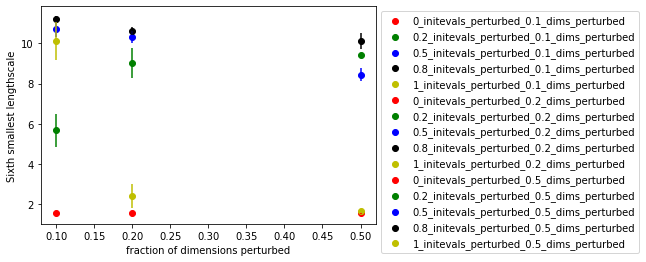

In [32]:
color = ['r', 'g', 'b', 'k', 'y']

for fdp in fracs_dims_perturbed:
    
    for fip, c in zip(fracs_initevals_perturbed, color):
        
        mean, sd = lengthscale_quantiles[('random', '30', fip , fdp, 'ub_and_lb')]
        plt.scatter(fdp, mean, c=c, label = str(fip) + '_initevals_perturbed_' + str(fdp) + '_dims_perturbed')
        plt.errorbar(fdp, mean, sd, c=c)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('fraction of dimensions perturbed')
plt.ylabel('Sixth smallest lengthscale')


In [33]:
# now plot objective value

start = 3

lengthscale_quantiles = {}

for perturb_dim_policy, n_initevals, frac_initevals_perturbed, frac_dims_perturbed, perturb_direction in combinations:

    qs = []

    frac_initevals_perturbed_str = str(frac_initevals_perturbed).replace('.', '')
    frac_dims_perturbed_str = str(frac_dims_perturbed).replace('.', '')

    for trial in trials:
        file = '/home/yz685/saasbo/results/' + problem + '/random_vs_dyadic/' + perturb_dim_policy + \
                '_initevals=' + n_initevals + '_frac_initevals_perturbed=' + frac_initevals_perturbed_str + \
                '_frac_dims_perturbed=' + frac_dims_perturbed_str + '/' + perturb_direction + str(trial)

        results = torch.load(file)
        print(results['Y'])
        #q, c, v = get_lengthscale_stats(np.expand_dims(results['median_lengthscales'][0], 0), thres = 5)
        #qs.append(q)
        
    q_mean, q_sd = process_multiple_trials(qs, log_transform = True)
    lengthscale_quantiles[(perturb_dim_policy, n_initevals, frac_initevals_perturbed, frac_dims_perturbed, perturb_direction)] = [q_mean, q_sd]
    
#     plt.plot(np.arange(3, len(q_mean)), q_mean[start:])
#     plt.fill_between(
#         np.arange(3, len(q_mean)),
#         q_mean[start:] - 2*q_sd[start:],
#         q_mean[start:] + 2*q_sd[start:],
#         alpha = 0.3,
#         label = perturb_dim_policy + '_' + perturb_direction
#     )
# plt.legend(bbox_to_anchor=(1, 1))
# plt.title('Log sixth smallest lengthscale in '+problem)

In [10]:
thres = 5

for perturb_dim_policy in perturb_dims_policies:
    for perturb_direction in perturb_directions:
        if perturb_dim_policy == 'dyadic_':
            fp_samples, fp_dims = '', ''
        else:
            fp_samples, fp_dims = perturb_dim_policy[-4], perturb_dim_policy[-2:]

        cs = []
        for trial in trials:
            file = '/home/yz685/saasbo/results/' + problem + '/random_vs_dyadic/' + perturb_dim_policy + '/' + perturb_direction \
                + str(trial) + '/median_lengthscales_' + fp_samples + '_' + fp_dims + '_' + str(trial) + '.npy'
            
            l = np.load(file)
            q, c, v = get_lengthscale_stats(l, thres = thres)
            cs.append(c)
            
        c_mean, c_sd = process_multiple_trials(cs, log_transform = False)
        plt.plot(c_mean)
        plt.fill_between(
            np.arange(len(c)),
            c_mean - 2*c_sd,
            c_mean + 2*c_sd,
            alpha = 0.3,
            label = perturb_dim_policy + '_' + perturb_direction
        )
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Number of dimensions with length scale less than ' + str(thres) + ' \n' + problem)
plt.xlabel('Number of function evaluations in the BO stage')

FileNotFoundError: [Errno 2] No such file or directory: '/home/yz685/saasbo/results/branin_1000/random_vs_dyadic/random/ub_only2/median_lengthscales_n_om_2.npy'

Text(0.5, 0, 'Number of function evaluations')

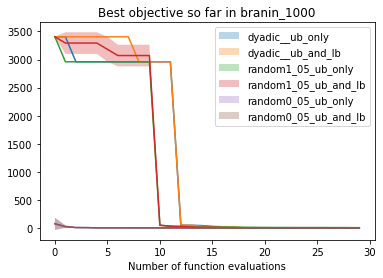

In [13]:

for perturb_dim_policy in perturb_dims_policies:
    for perturb_direction in perturb_directions:

        if perturb_dim_policy == 'dyadic_':
            fp_samples, fp_dims = '', ''
        else:
            fp_samples, fp_dims = perturb_dim_policy[-4], perturb_dim_policy[-2:]

        ys = []
        for trial in trials:
            file = '/home/yz685/saasbo/results/' + problem + '/random_vs_dyadic/' + perturb_dim_policy + '/' + perturb_direction \
                + str(trial) + '/output_at_X_' + fp_samples + '_' + fp_dims + '_' + str(trial) + '.npy'
            
            y = np.minimum.accumulate(np.load(file))
            ys.append(y)
            
        y_mean, y_sd = process_multiple_trials(ys)
        plt.plot(y_mean)
        plt.fill_between(
            np.arange(len(y)),
            y_mean - 2*y_sd,
            y_mean + 2*y_sd,
            alpha = 0.3,
            label = perturb_dim_policy + '_' + perturb_direction
        )
plt.legend()
plt.title('Best objective so far in ' + problem)
plt.xlabel('Number of function evaluations')

Text(0.5, 1.0, 'Average rankings of important dims in branin_1000 \n (dyadic vs random, ub_only vs ub_and_lb)')

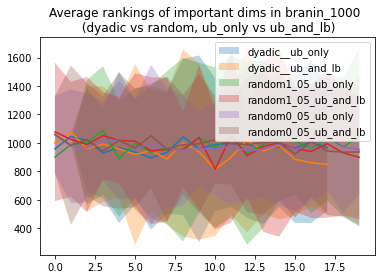

In [14]:
for perturb_dim_policy in perturb_dims_policies:
    for perturb_direction in perturb_directions:

        if perturb_dim_policy == 'dyadic_':
            fp_samples, fp_dims = '', ''
        else:
            fp_samples, fp_dims = perturb_dim_policy[-4], perturb_dim_policy[-2:]

        rs = []
        for trial in trials:
            file = '/home/yz685/saasbo/results/' + problem + '/random_vs_dyadic/' + perturb_dim_policy + '/' + perturb_direction \
                + str(trial) + '/lengthscale_rankings_' + fp_samples + '_' + fp_dims + '_' + str(trial) + '.npy'
        
            r = np.load(file)
            # print(r.shape)
            rs.append(r[:, important_dims])
            
        r_mean, r_sd = process_multiple_trials(rs)
        r_mean = np.mean(r_mean, axis = 1)
        r_sd = np.sum(r_sd, axis = 1) / np.sqrt(6)
        plt.plot(r_mean)
        plt.fill_between(
            np.arange(len(r)),
            r_mean - 2*r_sd,
            r_mean + 2*r_sd,
            alpha = 0.3,
            label = perturb_dim_policy + '_' + perturb_direction
        )
plt.legend()
plt.title('Average rankings of important dims in ' + problem + ' \n (dyadic vs random, ub_only vs ub_and_lb)')

# Vary a few control parameters in the random-perturbation setting:
* Fraction of initial evaluations to perturb
* Fraction of dimensions to perturb in each perturbed initial evaluation
* Direction of perturbation: set to upper bound with probabiltiy 1, or set to upper / lower bound with equal probability

In [21]:
Y_dict = {}
Q_dict = defaultdict(list)
C_dict = defaultdict(list)

frac_perturb_samples_list = [0.0, 0.8]
frac_perturb_dims_list = [0.1, 0.2, 0.5]

perturb_configs = [(f1, f2) for f1 in frac_perturb_samples_list for f2 in frac_perturb_dims_list]

# trials = [21, 22, 23, 24, 25]
trials = [11, 12, 13, 14, 15]
n_trials = len(trials)

In [75]:
for frac_perturb_samples_num, frac_perturb_dims_num in perturb_configs:

    frac_perturb_samples = str(frac_perturb_samples_num).replace('.', '')
    frac_perturb_dims = str(frac_perturb_dims_num).replace('.', '')

    Y = None
    Q = None
    C = None
    V = None
    for trial in trials:
        y = np.load('/home/yz685/saasbo/results/hartmann6_50/output_at_X/output_at_X_' \
            + frac_perturb_samples + '_' + frac_perturb_dims  + '_' + str(trial) + '.npy')
        y = np.expand_dims(np.minimum.accumulate(y), 0)
        if Y is None:
            Y = y 
        else:
            Y = np.vstack((Y, y))
        
        ell_median = np.load('/home/yz685/saasbo/results/hartmann6_50/median_lengthscales/median_lengthscales_' \
            + frac_perturb_samples + '_' + frac_perturb_dims  + '_' + str(trial) + '.npy')
        
        if len(ell_median.shape) > 1:        
            q, c, v = get_lengthscale_stats(ell_median, thres = 1)

            Q_dict[(frac_perturb_samples_num, frac_perturb_dims_num)].append(q)
            C_dict[(frac_perturb_samples_num, frac_perturb_dims_num)].append(c)
   

    
    Y_dict[(frac_perturb_samples_num, frac_perturb_dims_num)] = Y



    for i in ell_median[-1].argsort()[:6]:
        if i not in [1, 7, 11, 23, 47, 33]:
            print(f'Failed to identify important dimension {i} at {frac_perturb_samples_num} samples perturbed, {frac_perturb_dims_num} dimensions perturbed, trial {trial}')
            # print(f"Parameter {i:2} Median lengthscale = {ell_median[i]:.2e}")

Failed to identify important dimension 0 at 0.0 samples perturbed, 0.1 dimensions perturbed, trial 15
Failed to identify important dimension 0 at 0.0 samples perturbed, 0.2 dimensions perturbed, trial 15
Failed to identify important dimension 0 at 0.0 samples perturbed, 0.5 dimensions perturbed, trial 15
Failed to identify important dimension 0 at 0.8 samples perturbed, 0.1 dimensions perturbed, trial 15
Failed to identify important dimension 0 at 0.8 samples perturbed, 0.2 dimensions perturbed, trial 15
Failed to identify important dimension 0 at 0.8 samples perturbed, 0.5 dimensions perturbed, trial 15


In [105]:
test = [1,2,3,4,5]
k = [1,3, 6]

In [107]:
len(set(test).intersection(set(k)))

2

frac_pert_samples 0.0, frac_pert_dims 0.1, final value -2.9186004722734453
frac_pert_samples 0.0, frac_pert_dims 0.2, final value -2.95998516831239
frac_pert_samples 0.0, frac_pert_dims 0.5, final value -2.9434186414857724
frac_pert_samples 0.8, frac_pert_dims 0.1, final value -2.7279317260826006
frac_pert_samples 0.8, frac_pert_dims 0.2, final value -3.1604601695138035
frac_pert_samples 0.8, frac_pert_dims 0.5, final value -2.9863904697722643


Text(0.5, 1.0, 'Hartmann6 (d=6, D=50)')

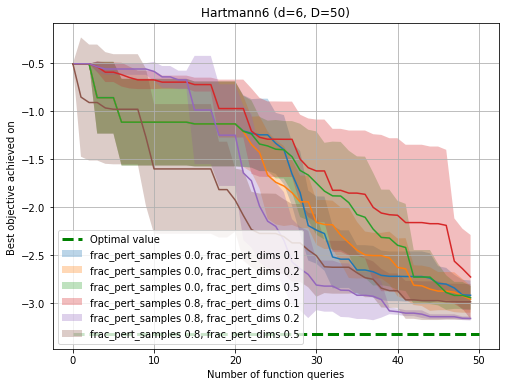

In [78]:
n_iters = 50

plt.figure(figsize=(8,6))
plt.plot([0, 50], [-3.322, -3.322], "--", c="g", lw=3, label="Optimal value")
plt.grid(True)

for frac_perturb_samples_num, frac_perturb_dims_num in Y_dict.keys():

    Y = Y_dict[(frac_perturb_samples_num, frac_perturb_dims_num)][:, :n_iters]

    Y_mean = np.mean(Y, axis = 0)

    plt.plot(Y_mean)
    plt.fill_between(
        np.arange(len(Y[0])),
        Y_mean - 2 * np.std(Y, axis=0) / (n_trials ** 0.5),
        Y_mean + 2 * np.std(Y, axis=0) / (n_trials ** 0.5),
        alpha = 0.3, label = 'frac_pert_samples {}, frac_pert_dims {}'.format(frac_perturb_samples_num, frac_perturb_dims_num)
    )

    print('frac_pert_samples {}, frac_pert_dims {}, final value {}'.format(frac_perturb_samples_num, frac_perturb_dims_num, Y_mean[-1]))

plt.legend()
plt.xlabel('Number of function queries') # seems liike I'm not including the initial ones
plt.ylabel('Best objective achieved on ')
plt.title('Hartmann6 (d=6, D=50)')

frac_pert_samples 0.0, frac_pert_dims 0.1, final value -1.9986854027171599
frac_pert_samples 0.0, frac_pert_dims 0.2, final value -1.9986854027171599
frac_pert_samples 0.0, frac_pert_dims 0.5, final value -1.9986854027171599
frac_pert_samples 1.0, frac_pert_dims 0.1, final value -1.9986854027171599
frac_pert_samples 1.0, frac_pert_dims 0.2, final value -1.9986854027171599
frac_pert_samples 1.0, frac_pert_dims 0.5, final value -1.9986854027171599


Text(0.5, 1.0, 'Hartmann6 (d=6, D=50)')

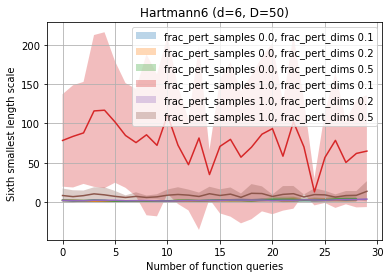

In [40]:
#plt.plot([0, 30], [-3.322, -3.322], "--", c="g", lw=3, label="Optimal value")
plt.grid(True)

for frac_perturb_samples_num, frac_perturb_dims_num in Q_dict.keys():

    if frac_perturb_samples_num == 0.8 and frac_perturb_dims_num == 0.1:
        continue

    Q = Q_dict[(frac_perturb_samples_num, frac_perturb_dims_num)]

    Q_mean = np.mean(Q, axis = 0)

    plt.plot(Q_mean)
    plt.fill_between(
        np.arange(len(Q[0])),
        Q_mean - 2 * np.std(Q, axis=0) / (n_trials ** 0.5),
        Q_mean + 2 * np.std(Q, axis=0) / (n_trials ** 0.5),
        alpha = 0.3, label = 'frac_pert_samples {}, frac_pert_dims {}'.format(frac_perturb_samples_num, frac_perturb_dims_num)
    )

    print('frac_pert_samples {}, frac_pert_dims {}, final value {}'.format(frac_perturb_samples_num, frac_perturb_dims_num, Y_mean[-1]))

plt.legend()
plt.xlabel('Number of function queries') # seems liike I'm not including the initial ones
plt.ylabel('Sixth smallest length scale ')
plt.title('Hartmann6 (d=6, D=50)')